### RBF Hyperparameter exploration

This document seeks to explore hyperparameters of a RBF approach to interpolation of a hypersurface in an example case as well as provide ideally modifiable code to do such a hyperparameter exploration for any data set.


In [1]:
%matplotlib inline 

import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import math
from mpl_toolkits.mplot3d import Axes3D

california_housing_dataframe_train = pd.read_csv("california_housing_train.csv", sep=",")
california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
    np.random.permutation(california_housing_dataframe_train.index))

california_housing_dataframe_test = pd.read_csv("california_housing_test.csv", sep=",")
california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
    np.random.permutation(california_housing_dataframe_test.index))

In [2]:
num_examples = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
test_examples = 20
L2Loss_all_0 = A=np.empty((len(num_examples),),dtype=object)
L2Loss_all_1 = A=np.empty((len(num_examples),),dtype=object)
L2Loss_all_01 = A=np.empty((len(num_examples),),dtype=object)


RankIssuesTot_0 = np.empty((len(num_examples),))
RankIssuesTot_1 = np.empty((len(num_examples),))
RankIssuesTot_01 = np.empty((len(num_examples),))


for num_example in num_examples:

    tempLoss_0 = []
    tempLoss_1 = []
    tempLoss_01 = []

    
    runs = 100
    tempRankIssues_0 = 0
    tempRankIssues_1 = 0
    tempRankIssues_01 = 0

    for run in range(runs):

        california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
            np.random.permutation(california_housing_dataframe_train.index))

        data_train = np.zeros([num_example,3]) 
        data_train[:,0] = california_housing_dataframe_train.median_house_value[0:(num_example)].values # Median house value for household within a block ($1)
        data_train[:,1] = california_housing_dataframe_train.population[0:(num_example)].values # population in block
        data_train[:,2] = california_housing_dataframe_train.median_income[0:(num_example)].values # Median income for households within a block ($10k)


        california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
            np.random.permutation(california_housing_dataframe_test.index))
        # I should be splitting the data into non-overlapping test and training examples, the only benefit of this is it allows some flexibility (if the training data set and the test data set together make up more than the total number of exampels I won't get an error here, I'll only get an error if either individually are too large)

        data_test = np.zeros([test_examples,3]) 
        data_test[:,0] = california_housing_dataframe_test.median_house_value[0:(test_examples)].values
        data_test[:,1] = california_housing_dataframe_test.population[0:(test_examples)].values
        data_test[:,2] = california_housing_dataframe_test.median_income[0:(test_examples)].values



        # Linear RBF interpolation (in 1D & 2D feature vectors)
        # Next hopefully I'll add loss and comparison to simple linear regression
        # Ultimately I want to have a switch-case here that allows users to choose their basis function. Ideally if they picked a paramterized basis they would be prompted to input paramters (or even better I guess the parameter space would be samples/explored)

        # Median House value -> income
        H_0 = np.zeros([num_example,num_example])
        # Block Population -> income
        H_1 = np.zeros([num_example,num_example])
        #Block Population*Population -> Income
        H_01 = np.zeros([num_example,num_example])


        for i in range(num_example): 
            for j in range(num_example):
                # Median House value -> income
                H_0[i,j] = (np.linalg.norm(data_train[j,0]-data_train[i,0]))
                # Block Population -> income
                H_1[i,j] = (np.linalg.norm(data_train[j,1]-data_train[i,1]))
                #Block Population*Population -> Income
                H_01[i,j] = (np.linalg.norm(data_train[j,[0,1]]-data_train[i,[0,1]]))

        
        # Median House value -> income
        if np.linalg.matrix_rank(H_0)==H_0.shape[1]:
            c_0 = np.matmul(np.linalg.inv(H_0),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_0 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_0[node]*np.linalg.norm(data_test[test_val,0]-data_train[node,0])
                y_hats_test_linear_0[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_0[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_0/datapoint = %s" %L2Loss_av)
            
            tempLoss_0 = np.append(tempLoss_0,L2Loss_av)
                            
        else: tempRankIssues_0 = tempRankIssues_0 + 1
            
            
        # Block Population -> income
        if np.linalg.matrix_rank(H_1)==H_1.shape[1]:
            c_1 = np.matmul(np.linalg.inv(H_1),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_1 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_1[node]*np.linalg.norm(data_test[test_val,1]-data_train[node,1])
                y_hats_test_linear_1[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_1[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_1/datapoint = %s" %L2Loss_av)
            
            tempLoss_1 = np.append(tempLoss_1,L2Loss_av)
                            
        else: tempRankIssues_1 = tempRankIssues_1 + 1
            
        #Block Population*Population -> Income
        if np.linalg.matrix_rank(H_01)==H_01.shape[1]:
            c_01 = np.matmul(np.linalg.inv(H_01),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_01 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_01[node]*np.linalg.norm(data_test[test_val,[0,1]]-data_train[node,[0,1]])
                y_hats_test_linear_01[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_01[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_01/datapoint = %s" %L2Loss_av)
            
            tempLoss_01 = np.append(tempLoss_01,L2Loss_av)
                            
        else: tempRankIssues_01 = tempRankIssues_01 + 1
            
    Indexx = int((num_example/10)-1)
    L2Loss_all_0[Indexx] = tempLoss_0
    L2Loss_all_1[Indexx] = tempLoss_1
    L2Loss_all_01[Indexx] = tempLoss_01

    RankIssuesTot_0[Indexx] = tempRankIssues_0/runs
    RankIssuesTot_1[Indexx] = tempRankIssues_1/runs
    RankIssuesTot_01[Indexx] = tempRankIssues_01/runs


L2Loss_0/datapoint = 5.8889258185512245
L2Loss_1/datapoint = 6.979279607458061
L2Loss_01/datapoint = 5.645538058318028
L2Loss_0/datapoint = 3.017711978032004
L2Loss_1/datapoint = 3.621784427251454
L2Loss_01/datapoint = 3.013459593038326
L2Loss_1/datapoint = 11.79216343821435
L2Loss_01/datapoint = 3.1512921709952195
L2Loss_0/datapoint = 2.7291032713792127
L2Loss_1/datapoint = 5.8888200025338655
L2Loss_01/datapoint = 2.7308321614996
L2Loss_0/datapoint = 4.750723469318492
L2Loss_1/datapoint = 10.207715366980533
L2Loss_01/datapoint = 4.734001630928052
L2Loss_0/datapoint = 7.586701742509341
L2Loss_1/datapoint = 2.389519678180108
L2Loss_01/datapoint = 7.593762077006433
L2Loss_0/datapoint = 2.7126191077835675
L2Loss_1/datapoint = 5.825771466247565
L2Loss_01/datapoint = 2.6023841662340605
L2Loss_0/datapoint = 1.5921091452146308
L2Loss_1/datapoint = 4.970542619335763
L2Loss_01/datapoint = 1.5964982761209205
L2Loss_0/datapoint = 9.563518588342124
L2Loss_1/datapoint = 53.36007864356384
L2Loss_01/

L2Loss_01/datapoint = 2.011043689369129
L2Loss_0/datapoint = 1.830625413361562
L2Loss_1/datapoint = 3.8676804199130443
L2Loss_01/datapoint = 1.8297047987328994
L2Loss_0/datapoint = 7.972076923082696
L2Loss_1/datapoint = 11.978577603937874
L2Loss_01/datapoint = 7.967705154561836
L2Loss_0/datapoint = 1.1588299987201374
L2Loss_1/datapoint = 2.244012254626346
L2Loss_01/datapoint = 0.9346177480929289
L2Loss_0/datapoint = 3.303801800482644
L2Loss_1/datapoint = 10.126343531173015
L2Loss_01/datapoint = 3.28879599605361
L2Loss_1/datapoint = 4.3992068913124704
L2Loss_01/datapoint = 1.6535794658864167
L2Loss_1/datapoint = 5.100065842669499
L2Loss_01/datapoint = 1.6249000224983547
L2Loss_0/datapoint = 9.862953301085271
L2Loss_1/datapoint = 5.696084085789113
L2Loss_01/datapoint = 9.887818946442234
L2Loss_0/datapoint = 5.3972154219492445
L2Loss_1/datapoint = 8.477816816898102
L2Loss_01/datapoint = 5.36504837234842
L2Loss_0/datapoint = 3.036850338231344
L2Loss_1/datapoint = 7.251085495321331
L2Loss_0

L2Loss_1/datapoint = 4.434109487195273
L2Loss_01/datapoint = 6.794860177968069
L2Loss_0/datapoint = 1.2234556607703921
L2Loss_1/datapoint = 2.1496409806356236
L2Loss_01/datapoint = 1.2305960732836385
L2Loss_0/datapoint = 2.903304943880029
L2Loss_1/datapoint = 3.63635003898987
L2Loss_01/datapoint = 2.9488176393981753
L2Loss_1/datapoint = 2.512225034040847
L2Loss_01/datapoint = 1.0673587028585176
L2Loss_1/datapoint = 5.5016896326629
L2Loss_01/datapoint = 2.709713542037755
L2Loss_0/datapoint = 4.000790533230464
L2Loss_01/datapoint = 4.050167244890877
L2Loss_0/datapoint = 5.051929596080651
L2Loss_1/datapoint = 33.309131538664616
L2Loss_01/datapoint = 4.891062404024096
L2Loss_1/datapoint = 2.6608310738282848
L2Loss_01/datapoint = 0.7056208121859252
L2Loss_0/datapoint = 2.7383307360333156
L2Loss_1/datapoint = 5.290024531079587
L2Loss_01/datapoint = 2.6847541938390242
L2Loss_1/datapoint = 5.499742288616373
L2Loss_01/datapoint = 3.2196837499194557
L2Loss_1/datapoint = 10.080624676792777
L2Loss

L2Loss_1/datapoint = 5.626960692802461
L2Loss_01/datapoint = 2.4747468839492557
L2Loss_1/datapoint = 3.19109054503368
L2Loss_01/datapoint = 1.9485441464815463
L2Loss_0/datapoint = 2.763667578546026
L2Loss_1/datapoint = 4.559023998015796
L2Loss_01/datapoint = 2.6697975259663247
L2Loss_1/datapoint = 3.58420706930033
L2Loss_01/datapoint = 3.084590773623673
L2Loss_1/datapoint = 5.429397134587246
L2Loss_01/datapoint = 2.0865973048034485
L2Loss_0/datapoint = 3.4830333488969756
L2Loss_1/datapoint = 5.1815690218202946
L2Loss_01/datapoint = 3.5186273586734407
L2Loss_1/datapoint = 4.000875169868445
L2Loss_01/datapoint = 1.9449199094646867
L2Loss_0/datapoint = 1.4069933409704218
L2Loss_1/datapoint = 6.218164383940217
L2Loss_01/datapoint = 1.4041103674175672
L2Loss_01/datapoint = 2.862836600325302
L2Loss_1/datapoint = 13.75836887273556
L2Loss_01/datapoint = 2.377050916640413
L2Loss_0/datapoint = 1.9435933692886695
L2Loss_1/datapoint = 4.329105165498086
L2Loss_01/datapoint = 1.8977569185525662
L2Lo

L2Loss_01/datapoint = 1.6787533648710258
L2Loss_0/datapoint = 4.463184974531426
L2Loss_1/datapoint = 8.732797899061227
L2Loss_01/datapoint = 4.507782141304118
L2Loss_01/datapoint = 1.3010812341589255
L2Loss_01/datapoint = 3.960355544130502
L2Loss_1/datapoint = 6.3388822033589936
L2Loss_01/datapoint = 0.9784374526569396
L2Loss_0/datapoint = 1.37499127653684
L2Loss_1/datapoint = 4.26009311667392
L2Loss_01/datapoint = 1.3584309494296365
L2Loss_1/datapoint = 4.996917820263421
L2Loss_01/datapoint = 1.7835601767535478
L2Loss_1/datapoint = 7.3104348229941705
L2Loss_01/datapoint = 3.622933939767255
L2Loss_0/datapoint = 1.839512626018483
L2Loss_1/datapoint = 4.149431073669964
L2Loss_01/datapoint = 1.7422840908486812
L2Loss_0/datapoint = 2.098100715961171
L2Loss_01/datapoint = 1.9216672809276036
L2Loss_0/datapoint = 3.03839638900936
L2Loss_1/datapoint = 4.219930315901382
L2Loss_01/datapoint = 2.803227236417297
L2Loss_1/datapoint = 2.389879129782898
L2Loss_01/datapoint = 7.912135591770612
L2Loss_

L2Loss_1/datapoint = 10.85045863464561
L2Loss_01/datapoint = 3.337590246611577
L2Loss_0/datapoint = 7.697697723231822
L2Loss_1/datapoint = 8.315875476154861
L2Loss_01/datapoint = 7.761324512773646
L2Loss_1/datapoint = 13.047147552033811
L2Loss_01/datapoint = 3.4553731708793514
L2Loss_1/datapoint = 12.061342900339854
L2Loss_01/datapoint = 2.364427241264324
L2Loss_01/datapoint = 3.9362117863387502
L2Loss_1/datapoint = 7.216851701965285
L2Loss_01/datapoint = 3.7612981526434632
L2Loss_0/datapoint = 5.588460405545189
L2Loss_1/datapoint = 4.417082105621608
L2Loss_01/datapoint = 5.530140062837491
L2Loss_1/datapoint = 6.252305437729066
L2Loss_01/datapoint = 6.528563001408488
L2Loss_1/datapoint = 7.751739992620097
L2Loss_01/datapoint = 5.7141902784208485
L2Loss_1/datapoint = 9.68429295137419
L2Loss_01/datapoint = 3.161669381706316
L2Loss_0/datapoint = 1.6748278935996024
L2Loss_1/datapoint = 6.596828414679284
L2Loss_01/datapoint = 1.6927931068017572
L2Loss_1/datapoint = 4.3677058810024025
L2Loss

L2Loss_01/datapoint = 0.8090224343144212
L2Loss_1/datapoint = 2.6621509945630986
L2Loss_01/datapoint = 2.5641018393347816
L2Loss_01/datapoint = 2.1097092072636547
L2Loss_1/datapoint = 2.779692931163795
L2Loss_01/datapoint = 2.213068602785087
L2Loss_1/datapoint = 3.9436723880914486
L2Loss_01/datapoint = 1.7811371120313098
L2Loss_01/datapoint = 3.5978090618080145
L2Loss_1/datapoint = 4.838064023884828
L2Loss_01/datapoint = 2.003803015010468
L2Loss_1/datapoint = 8.059313421002187
L2Loss_01/datapoint = 1.9199122109479982
L2Loss_0/datapoint = 1.4768650234437184
L2Loss_1/datapoint = 3.7076234331876465
L2Loss_01/datapoint = 1.6101981381397632
L2Loss_1/datapoint = 6.992095143489449
L2Loss_01/datapoint = 4.611618598034317
L2Loss_01/datapoint = 1.7976326924121462
L2Loss_1/datapoint = 3.351767822137633
L2Loss_01/datapoint = 1.9634725701422397
L2Loss_1/datapoint = 5.155403629644821
L2Loss_01/datapoint = 1.9743777071317328
L2Loss_01/datapoint = 2.4686868064631784
L2Loss_01/datapoint = 3.72244339750

L2Loss_01/datapoint = 3.5750267743732396
L2Loss_01/datapoint = 2.8696759027713497
L2Loss_01/datapoint = 3.102763373541369
L2Loss_01/datapoint = 1.9921875492260905
L2Loss_01/datapoint = 2.2977500420318107
L2Loss_1/datapoint = 9.613160401704805
L2Loss_01/datapoint = 1.9838567128017626
L2Loss_1/datapoint = 3.9644293775365123
L2Loss_01/datapoint = 2.004311372903713
L2Loss_01/datapoint = 6.149248526510521
L2Loss_01/datapoint = 4.020559977745835
L2Loss_01/datapoint = 2.0781332777395836
L2Loss_01/datapoint = 2.961161509441043
L2Loss_01/datapoint = 2.6311577162705495
L2Loss_01/datapoint = 1.4792531398279518
L2Loss_1/datapoint = 12.674179982065006
L2Loss_01/datapoint = 1.2828233321636255
L2Loss_1/datapoint = 6.194018311129655
L2Loss_01/datapoint = 3.0101938766183194
L2Loss_01/datapoint = 2.5905427071887983
L2Loss_01/datapoint = 1.9125668931548376
L2Loss_1/datapoint = 8.587087632871434
L2Loss_01/datapoint = 3.948223405601079
L2Loss_01/datapoint = 2.41107959498484
L2Loss_01/datapoint = 3.72733098

L2Loss_01/datapoint = 0.9017574163263011
L2Loss_01/datapoint = 4.0936690368086435
L2Loss_01/datapoint = 4.404663194142557
L2Loss_01/datapoint = 1.6051205279842062
L2Loss_01/datapoint = 5.030436505438739
L2Loss_01/datapoint = 1.7560224918167475
L2Loss_01/datapoint = 2.5381063980241985
L2Loss_01/datapoint = 5.358226874383743
L2Loss_01/datapoint = 1.8058093900016796
L2Loss_01/datapoint = 1.9428404503205197
L2Loss_1/datapoint = 1.700002693537251
L2Loss_01/datapoint = 3.4574664987081385
L2Loss_1/datapoint = 3.4509268627787044
L2Loss_01/datapoint = 6.382825852942714
L2Loss_01/datapoint = 2.7393743925035365
L2Loss_01/datapoint = 3.6885796285325805
L2Loss_01/datapoint = 2.1699901107087936
L2Loss_1/datapoint = 6.85457597999319
L2Loss_01/datapoint = 1.541598583181929
L2Loss_1/datapoint = 4.363978873990465
L2Loss_01/datapoint = 1.8982579995981
L2Loss_01/datapoint = 1.233197485888303
L2Loss_01/datapoint = 6.08928404678925
L2Loss_01/datapoint = 1.3356716275523113
L2Loss_01/datapoint = 1.89676469073

L2Loss_01/datapoint = 1.5560655860970911
L2Loss_01/datapoint = 1.368758360902771
L2Loss_01/datapoint = 1.875978001576442
L2Loss_01/datapoint = 2.608770509955156
L2Loss_01/datapoint = 2.8148150226965503
L2Loss_01/datapoint = 1.6470851780993154
L2Loss_01/datapoint = 1.916105226541531
L2Loss_01/datapoint = 4.753615411874584
L2Loss_01/datapoint = 1.7305499650870648
L2Loss_01/datapoint = 2.2687359020017936
L2Loss_01/datapoint = 3.7039622637049754
L2Loss_01/datapoint = 2.199980919801279
L2Loss_01/datapoint = 8.117854213273489
L2Loss_01/datapoint = 3.814645746579545
L2Loss_1/datapoint = 6.9605205064505755
L2Loss_01/datapoint = 1.9268116381950229
L2Loss_01/datapoint = 3.436395488937363
L2Loss_01/datapoint = 3.503042575379703
L2Loss_01/datapoint = 1.6171488060357675
L2Loss_01/datapoint = 3.311113629029184
L2Loss_01/datapoint = 5.161996009840566
L2Loss_01/datapoint = 2.499781944657507
L2Loss_01/datapoint = 3.961994095898837
L2Loss_01/datapoint = 2.560725136204584
L2Loss_01/datapoint = 1.67117174

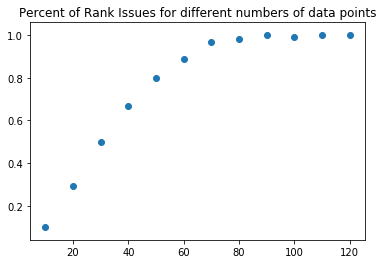

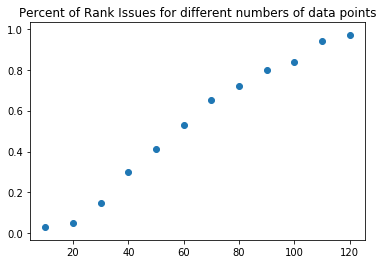

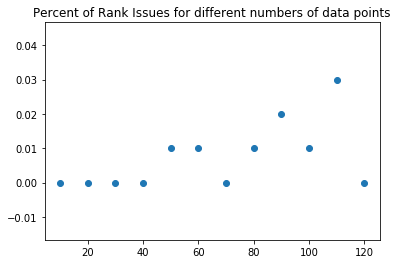

In [3]:
plt.scatter(num_examples, RankIssuesTot_0);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(num_examples, RankIssuesTot_1);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

plt.scatter(num_examples, RankIssuesTot_01);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

In [4]:
RankIssuesTot_01

array([0.  , 0.  , 0.  , 0.  , 0.01, 0.01, 0.  , 0.01, 0.02, 0.01, 0.03,
       0.  ])

In [5]:
AllIssueofRank_0 = (np.where(RankIssuesTot_0 == 1))

L2Loss_all_modified_0 = L2Loss_all_0
num_examples_modified_0 = num_examples

flag = 0
while flag < len(AllIssueofRank_0[0]):
    L2Loss_all_modified_0 = np.delete(L2Loss_all_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    num_examples_modified_0 = np.delete(num_examples_modified_0,AllIssueofRank_0[0][len(AllIssueofRank_0[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_1 = (np.where(RankIssuesTot_1 == 1))

L2Loss_all_modified_1 = L2Loss_all_1
num_examples_modified_1 = num_examples

flag = 0
while flag < len(AllIssueofRank_1[0]):
    L2Loss_all_modified_1 = np.delete(L2Loss_all_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    num_examples_modified_1 = np.delete(num_examples_modified_1,AllIssueofRank_1[0][len(AllIssueofRank_1[0])-(1+flag)])
    
    flag = flag + 1
    
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))

L2Loss_all_modified_01 = L2Loss_all_01
num_examples_modified_01 = num_examples

flag = 0
while flag < len(AllIssueofRank_01[0]):
    L2Loss_all_modified_01 = np.delete(L2Loss_all_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    num_examples_modified_01 = np.delete(num_examples_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    
    flag = flag + 1

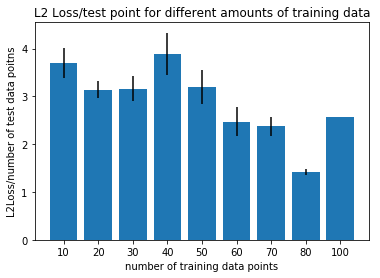

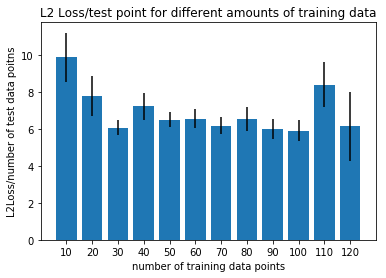

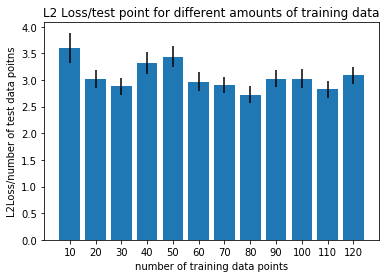

In [6]:
num4It = (len(L2Loss_all_modified_0))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_0[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_0[stttats])/math.sqrt(len(L2Loss_all_modified_0[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_0[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_0)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_1))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_1[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_1[stttats])/math.sqrt(len(L2Loss_all_modified_1[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_1[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_1)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

num4It = (len(L2Loss_all_modified_01))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_01[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_01[stttats])/math.sqrt(len(L2Loss_all_modified_01[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_01[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_01)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()

In [7]:
num_examples = [50, 100, 150, 200, 250]
test_examples = 20
L2Loss_all_01 = A=np.empty((len(num_examples),),dtype=object)
RankIssuesTot_01 = np.empty((len(num_examples),))


for num_example in num_examples:

    tempLoss_01 = []

    runs = 100
    tempRankIssues_01 = 0

    for run in range(runs):

        california_housing_dataframe_train = california_housing_dataframe_train.reindex( 
            np.random.permutation(california_housing_dataframe_train.index))

        data_train = np.zeros([num_example,3]) 
        data_train[:,0] = california_housing_dataframe_train.median_house_value[0:(num_example)].values # Median house value for household within a block ($1)
        data_train[:,1] = california_housing_dataframe_train.population[0:(num_example)].values # population in block
        data_train[:,2] = california_housing_dataframe_train.median_income[0:(num_example)].values # Median income for households within a block ($10k)


        california_housing_dataframe_test = california_housing_dataframe_test.reindex( 
            np.random.permutation(california_housing_dataframe_test.index))
        # I should be splitting the data into non-overlapping test and training examples, the only benefit of this is it allows some flexibility (if the training data set and the test data set together make up more than the total number of exampels I won't get an error here, I'll only get an error if either individually are too large)

        data_test = np.zeros([test_examples,3]) 
        data_test[:,0] = california_housing_dataframe_test.median_house_value[0:(test_examples)].values
        data_test[:,1] = california_housing_dataframe_test.population[0:(test_examples)].values
        data_test[:,2] = california_housing_dataframe_test.median_income[0:(test_examples)].values

        H_01 = np.zeros([num_example,num_example])

        for i in range(num_example): 
            for j in range(num_example):
                #Block Population*Population -> Income
                H_01[i,j] = (np.linalg.norm(data_train[j,[0,1]]-data_train[i,[0,1]]))
                
        #Block Population*Population -> Income
        if np.linalg.matrix_rank(H_01)==H_01.shape[1]:
            c_01 = np.matmul(np.linalg.inv(H_01),np.reshape(data_train[:,2],[num_example,1]))
            y_hats_test_linear_01 = np.zeros(test_examples)

            for test_val in range(test_examples):
                temp = 0
                for node in range(num_example):
                    temp = temp + c_01[node]*np.linalg.norm(data_test[test_val,[0,1]]-data_train[node,[0,1]])
                y_hats_test_linear_01[test_val] = temp    

            #Loss calculation
            y_est = np.zeros([test_examples,1]); L2Loss = 0

            for i in range(0,(test_examples)):
                L2Loss = L2Loss + (data_test[i,2]-(y_hats_test_linear_01[i]))**2
                L2Loss_av = L2Loss/test_examples
            print("L2Loss_01/datapoint = %s" %L2Loss_av)
            
            tempLoss_01 = np.append(tempLoss_01,L2Loss_av)
                            
        else: tempRankIssues_01 = tempRankIssues_01 + 1
            
    Indexx = int((num_example/50)-1)
    L2Loss_all_01[Indexx] = tempLoss_01
    RankIssuesTot_01[Indexx] = tempRankIssues_01/runs

L2Loss_01/datapoint = 1.362907239336176
L2Loss_01/datapoint = 1.0802660493906653
L2Loss_01/datapoint = 4.132416550758861
L2Loss_01/datapoint = 1.804136065263723
L2Loss_01/datapoint = 2.2283770623024632
L2Loss_01/datapoint = 2.723970309885231
L2Loss_01/datapoint = 1.956878328940816
L2Loss_01/datapoint = 2.3307544540073595
L2Loss_01/datapoint = 2.0257569061677625
L2Loss_01/datapoint = 0.9390321489826
L2Loss_01/datapoint = 3.2582546811733124
L2Loss_01/datapoint = 2.7416755725323503
L2Loss_01/datapoint = 1.1645265597299306
L2Loss_01/datapoint = 2.5629077062378696
L2Loss_01/datapoint = 3.4727572194091594
L2Loss_01/datapoint = 3.322448026467677
L2Loss_01/datapoint = 1.8638729679381307
L2Loss_01/datapoint = 2.883788373416892
L2Loss_01/datapoint = 1.1721255107559758
L2Loss_01/datapoint = 1.634041423966958
L2Loss_01/datapoint = 4.652044073914033
L2Loss_01/datapoint = 3.1540478160559133
L2Loss_01/datapoint = 1.1924666977130796
L2Loss_01/datapoint = 3.6690015994230856
L2Loss_01/datapoint = 3.2005

L2Loss_01/datapoint = 13.289290306986667
L2Loss_01/datapoint = 3.2863169650389255
L2Loss_01/datapoint = 1.7568556448722998
L2Loss_01/datapoint = 2.32172201415063
L2Loss_01/datapoint = 1.4032265763710947
L2Loss_01/datapoint = 8.019309630698617
L2Loss_01/datapoint = 3.273271678961234
L2Loss_01/datapoint = 2.5493151930736686
L2Loss_01/datapoint = 2.574290155665612
L2Loss_01/datapoint = 1.7276654680650285
L2Loss_01/datapoint = 6.664521860958334
L2Loss_01/datapoint = 1.6356173124115188
L2Loss_01/datapoint = 9.175601968235544
L2Loss_01/datapoint = 1.7940084283661917
L2Loss_01/datapoint = 1.3344762519757616
L2Loss_01/datapoint = 6.431255636676049
L2Loss_01/datapoint = 2.506421860303667
L2Loss_01/datapoint = 2.8209286865231333
L2Loss_01/datapoint = 4.025038240134284
L2Loss_01/datapoint = 3.0351665390127027
L2Loss_01/datapoint = 1.199569600115769
L2Loss_01/datapoint = 4.747633233567661
L2Loss_01/datapoint = 4.4564771065011906
L2Loss_01/datapoint = 2.0088727170526095
L2Loss_01/datapoint = 2.7454

L2Loss_01/datapoint = 2.8116901493311515
L2Loss_01/datapoint = 2.6340993779978232
L2Loss_01/datapoint = 1.962210047129337
L2Loss_01/datapoint = 0.9842516369927401
L2Loss_01/datapoint = 2.618608876662556
L2Loss_01/datapoint = 3.0479419009053625
L2Loss_01/datapoint = 1.1289087694858277
L2Loss_01/datapoint = 1.380342088635349
L2Loss_01/datapoint = 2.127751780477925
L2Loss_01/datapoint = 3.776153400345154
L2Loss_01/datapoint = 6.414571971702264
L2Loss_01/datapoint = 2.968000172303504
L2Loss_01/datapoint = 5.227921058047785
L2Loss_01/datapoint = 0.9659001000045329
L2Loss_01/datapoint = 6.670438906989385
L2Loss_01/datapoint = 4.5369952375996565
L2Loss_01/datapoint = 9.633473084973675
L2Loss_01/datapoint = 3.0944569365585872
L2Loss_01/datapoint = 2.0091711289432572
L2Loss_01/datapoint = 1.8498000770051077
L2Loss_01/datapoint = 1.797601466706261
L2Loss_01/datapoint = 1.4946519266273428
L2Loss_01/datapoint = 1.4321102650989133
L2Loss_01/datapoint = 5.583129502580914
L2Loss_01/datapoint = 5.0802

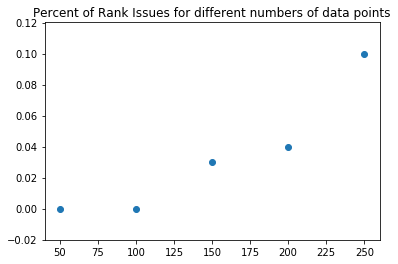

In [8]:
plt.scatter(num_examples, RankIssuesTot_01);
plt.title('Percent of Rank Issues for different numbers of data points')
plt.show()

In [9]:
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))
AllIssueofRank_01

(array([], dtype=int64),)

In [10]:
AllIssueofRank_01 = (np.where(RankIssuesTot_01 == 1))

L2Loss_all_modified_01 = L2Loss_all_01
num_examples_modified_01 = num_examples

flag = 0
while flag < len(AllIssueofRank_01[0]):
    L2Loss_all_modified_01 = np.delete(L2Loss_all_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    num_examples_modified_01 = np.delete(num_examples_modified_01,AllIssueofRank_01[0][len(AllIssueofRank_01[0])-(1+flag)])
    
    flag = flag + 1

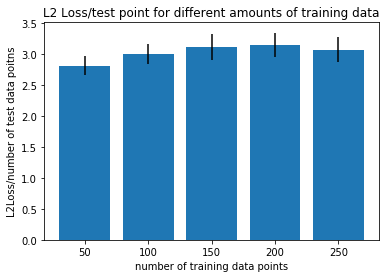

In [11]:
num4It = (len(L2Loss_all_modified_01))
meanlist = np.empty((num4It,))
sterrlist = np.empty((num4It,))
stdlist = np.empty((num4It,))

for stttats in range(num4It):
    meanlist[stttats] = np.mean(L2Loss_all_modified_01[stttats])
    sterrlist[stttats] = np.std(L2Loss_all_modified_01[stttats])/math.sqrt(len(L2Loss_all_modified_01[stttats]))
    stdlist[stttats] = np.std(L2Loss_all_modified_01[stttats])
    
x_pos = range(num4It)
fig, ax = plt.subplots()
ax.bar(x_pos,meanlist, yerr = sterrlist)

plt.title('L2 Loss/test point for different amounts of training data')    
plt.xticks(x_pos,num_examples_modified_01)
plt.xlabel('number of training data points')
plt.ylabel('L2Loss/number of test data poitns')
plt.show()